## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

import numpy as np
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier


## MNIST (0-4) vs MNIST (5-9)

### Data and model loading
ID data: MNIST (0-4), OOD data: MNIST (5-9)

In [2]:
oods_test = OODDataset('mnist', split="test")
oods_train = OODDataset('mnist', split="train")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)


def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:

model_path = os.path.expanduser("~/") + "saved_models/mnist_model_0-4/"

try:
    model = tf.keras.models.load_model(model_path)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 5,
        "optimizer": "adam",
        "save_dir": model_path,
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(oods_train.get_dataset(), **train_config) #ds_fit is actually the train set of MNIST

Epoch 1/5
    240/Unknown - 8s 19ms/step - loss: 0.7341 - accuracy: 0.7167

INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


240/240 [==============================] - 12s 35ms/step - loss: 0.7341 - accuracy: 0.7167 - val_loss: 0.1605 - val_accuracy: 0.9564
Epoch 2/5
239/240 [============================>.] - ETA: 0s - loss: 0.3275 - accuracy: 0.8844

INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


240/240 [==============================] - 7s 28ms/step - loss: 0.3275 - accuracy: 0.8844 - val_loss: 0.1211 - val_accuracy: 0.9656
Epoch 3/5
240/240 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9083

INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


240/240 [==============================] - 7s 29ms/step - loss: 0.2675 - accuracy: 0.9083 - val_loss: 0.1110 - val_accuracy: 0.9704
Epoch 4/5
240/240 [==============================] - 5s 21ms/step - loss: 0.2391 - accuracy: 0.9178 - val_loss: 0.1049 - val_accuracy: 0.9691
Epoch 5/5
238/240 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9244

INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model_0-4/assets


240/240 [==============================] - 7s 30ms/step - loss: 0.2223 - accuracy: 0.9245 - val_loss: 0.0834 - val_accuracy: 0.9788


### DKNN score

auroc       0.968776
fpr95tpr    0.133489
Name: mnist-0-4-vs-5-10, dtype: float64


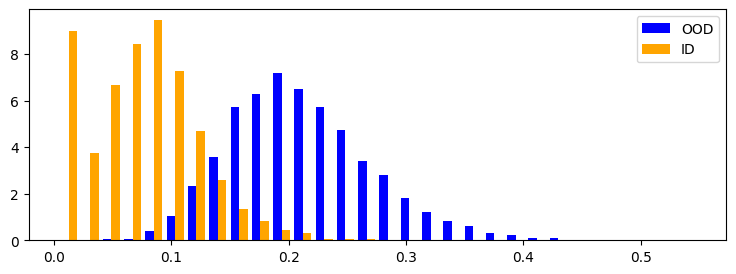

In [4]:
batch_size = 128

oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train.take(10000))
scores_in = oodmodel.score(ds_in.take(1000))
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    )

metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("OOD", "ID"), density=True)
plt.legend()
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [5]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_fit = OODDataset('mnist', split="train")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

In [6]:
try:
    model = tf.keras.models.load_model("./saved_models/mnist_model")
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "optimizer": "adam",
        "epochs": 5,
        "save_dir": "./saved_models/mnist_model",
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(oods_fit.get_dataset(), **train_config) #

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.6107

INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


469/469 [==============================] - 15s 27ms/step - loss: 1.1297 - accuracy: 0.6107 - val_loss: 0.4238 - val_accuracy: 0.8715
Epoch 2/5
469/469 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.7813

INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


469/469 [==============================] - 12s 25ms/step - loss: 0.6596 - accuracy: 0.7813 - val_loss: 0.3099 - val_accuracy: 0.9107
Epoch 3/5
468/469 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.8218

INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


469/469 [==============================] - 12s 26ms/step - loss: 0.5475 - accuracy: 0.8218 - val_loss: 0.2660 - val_accuracy: 0.9211
Epoch 4/5
469/469 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.8453

INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


469/469 [==============================] - 12s 25ms/step - loss: 0.4784 - accuracy: 0.8453 - val_loss: 0.2287 - val_accuracy: 0.9325
Epoch 5/5
468/469 [============================>.] - ETA: 0s - loss: 0.4311 - accuracy: 0.8611

INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


INFO:tensorflow:Assets written to: ./saved_models/mnist_model/assets


469/469 [==============================] - 13s 27ms/step - loss: 0.4309 - accuracy: 0.8612 - val_loss: 0.2075 - val_accuracy: 0.9379


### DKNN score

auroc       0.993552
fpr95tpr    0.027500
Name: mnist-10-vs-fashion, dtype: float64


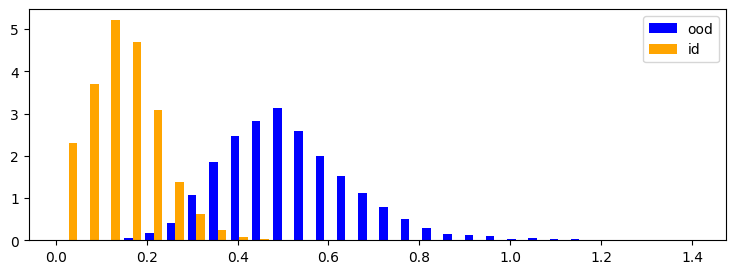

In [7]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_fit.take(10000))
scores_in = oodmodel.score(ds_in.take(1000))
scores_out = oodmodel.score(ds_out.take(1000))


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## CIFAR-10 vs [SVHN, LSUN, iSUN, Texture]

### ID Data and model loading

In [3]:
%autoreload 2

oods_in = OODDataset('cifar10', split="test", input_key="image")
oods_fit = OODDataset('cifar10', split="train", input_key="image")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
from oodeel.models.training_funs import train_keras_app

try:
    model = tf.keras.models.load_model("./saved_models/cifar10/")
    
except OSError:
    train_config = {
        "input_shape": (32, 32, 3),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 60,
        "learning_rate": 1e-1,
        #"optimizer": "adam",
        "save_dir": "./saved_models/cifar10/",
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_keras_app(oods_fit.get_dataset(), "resnet18", **train_config) 

KeyboardInterrupt: 

### OOD data: SVHN
ID data: CIFAR-10, OOD data: SVHN

In [ ]:
# ood dataset
oodmodel = DKNN(nearest=50, output_layers_id=[-3])
oodmodel.fit(model, ds_fit.take(10000))
scores_in = oodmodel.score(ds_in.take(1000))


2023-03-10 08:43:38.144135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-10 08:43:47.414853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-10 08:43:52.570620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-03-10 08:40:21.380501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


auroc       0.405367
fpr95tpr    0.937200
Name: cifar-vs-svhn, dtype: float64


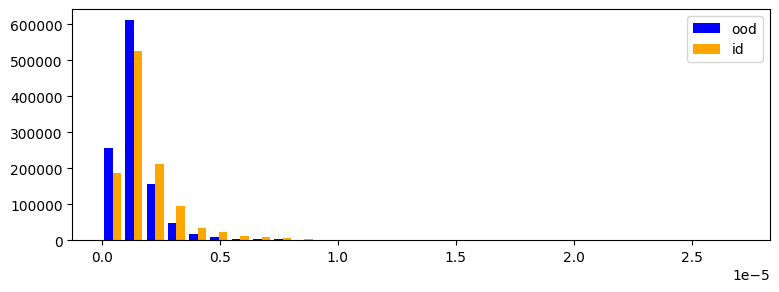

In [ ]:
# In tensorflow_datasets, SVHN has an "extra" split of 500000 samples, so we use keras.datasets loader
oods_out = OODDataset('svhn_cropped', split="test", input_key="image")
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_svhn = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

### OOD data: LSUN
ID data: CIFAR-10, OOD data: LSUN

Found 10000 files belonging to 1 classes.


2023-02-04 01:04:43.879091: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.998942
fpr95tpr    0.002600
Name: cifar-vs-lsun, dtype: float64


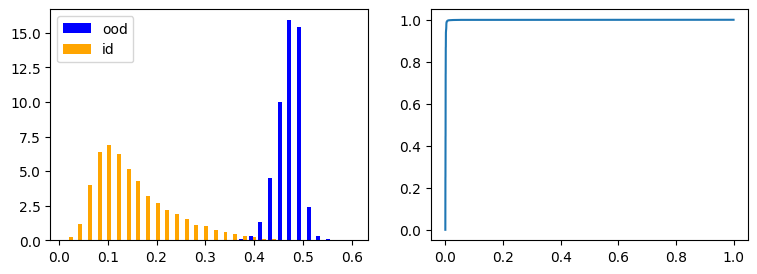

In [ ]:
import tensorflow as tf
LSUN_root = "~/datasets/LSUN"
lsun_ds = tf.keras.utils.image_dataset_from_directory(
    LSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
ds_out = OODDataset(lsun_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_lsun = pd.Series(metrics, name='cifar-vs-lsun')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

### OOD data: iSUN
ID data: CIFAR-10, OOD data: iSUN

Found 8925 files belonging to 1 classes.


2023-02-04 01:21:25.941738: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.997885
fpr95tpr    0.004600
Name: cifar-vs-isun, dtype: float64


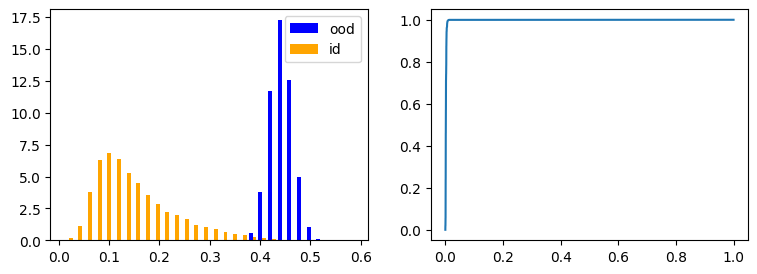

In [ ]:
import tensorflow as tf
iSUN_root = "~/datasets/iSUN"
isun_ds = tf.keras.utils.image_dataset_from_directory(
    iSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
x_ood = OODDataset(isun_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_isun = pd.Series(metrics, name='cifar-vs-isun')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

### OOD data: Texture
ID data: CIFAR-10, OOD data: Texture

Found 5640 files belonging to 47 classes.


2023-02-04 01:29:33.423863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.997419
fpr95tpr    0.006700
Name: cifar-vs-texture, dtype: float64


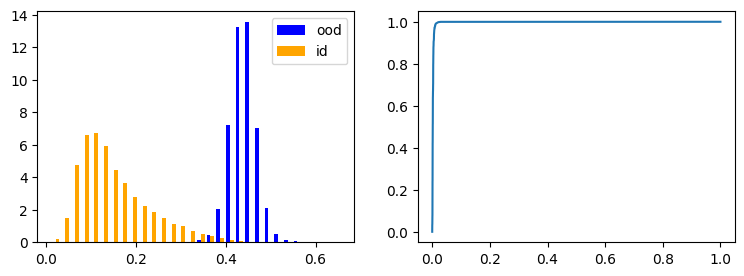

In [ ]:
import tensorflow as tf
texture_root = "~/datasets/dtd"
texture_ds = tf.keras.utils.image_dataset_from_directory(
    texture_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None,
)
# ood dataset
x_ood = OODDataset(texture_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_texture = pd.Series(metrics, name='cifar-vs-texture')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## Results

In [ ]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

,auroc,fpr95tpr
mnist-0-4-vs-5-10,0.975215,0.107803
mnist-10-vs-fashion,0.997144,0.010400
cifar-vs-svhn,0.865995,0.370100
cifar-vs-lsun,0.998942,0.002600
cifar-vs-isun,0.997885,0.004600
cifar-vs-texture,0.997419,0.006700
